In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import json
import matplotlib.pyplot as plt
#import statsmodels.tsa.stattools as ts
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
#from functions.evolutionaryalgo import quadratic_loss_function
from functions.inequality import gini, lorenz_curve
from distribution_model import *
import statsmodels.api as sm
from SALib.sample import latin
from matplotlib import style
from collections import OrderedDict
from functions.indirect_calibration import distr_model_performance
import seaborn as sns
import scipy.stats as stats
import scipy
from functions.find_bubbles import *
from statsmodels.iolib.summary2 import summary_col

In [2]:
style.use('ggplot')

# Experiment change share of chartists. 

In [22]:
NRUNS = 5

In [4]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())

Fix the learning ability at 0.0

In [5]:
params['average_learning_ability'] = 0.0

Increment the share of chartists from 0.0 to 100

In [13]:
share_chartists = [x / 100.0 for x in range(0, 102, 2)]

## Run model and update share chartists every time

In [16]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    params['strat_share_chartists'] = share_chartists[seed]
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  10
Start of simulation  11
Start of simulation  12
Start of simulation  13
Start of simulation  14
Start of simulation  15
Start of simulation  16
Start of simulation  17
Start of simulation  18
Start of simulation  19
Start of simulation  20
Start of simulation  21
Start of simulation  22
Start of simulation  23
Start of simulation  24
Start of simulation  25
Start of simulation  26
Start of simulation  27
Start of simulation  28
Start of simulation  29
Start of simulation  30
Start of simulation  31
Start of simulation  32
Start of simulation  33
Start of simulation  34
Start of simulation  35
Start of simulation  36
Start of simulation  37
Start of simulation  38
Start of simulation  39
Start of simulation  40
Start of simulation  41
St

Structure the data

In [49]:
ginis = []
palmas = []
twtws = []
asset_price_inflation = []
price_to_div_stdev = []

for idx, traders in enumerate(trdrs):
    #print(t)
    money = np.array([x.var.money[-1] for x in trdrs[idx]])
    stocks = np.array([x.var.stocks[-1] for x in trdrs[idx]])
    wealth = money + (stocks * orbs[idx].tick_close_price[-1])
    
    asset_price_inflation.append(orbs[idx].tick_close_price[-1] - orbs[idx].tick_close_price[0])
    price_to_div_stdev.append((pd.Series(orbs[idx].tick_close_price) / pd.Series(orbs[idx].fundamental[1:])).std())
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palmas.append(share_top_10 / share_bottom_40)
    
    share_top_20 = sum(np.sort(wealth)[int(len(wealth) * 0.8):]) / sum(wealth)
    share_bottom_20 = sum(np.sort(wealth)[:int(len(wealth) * 0.2)]) / sum(wealth)
    twtws.append(share_top_20 / share_bottom_20)
    
    ginis.append(gini(wealth))

In [58]:
data = pd.DataFrame({'gini': np.log(ginis[1:]), 'palma': np.log(palmas[1:]), 'twtw': np.log(twtws[1:]), 'pd_vol': price_to_div_stdev[1:],
                     'share_chartists': np.log(share_chartists[1:]), 'lin_share_chartists': share_chartists[1:], 'asset_price_infl': asset_price_inflation[1:]})
data['const'] = 1

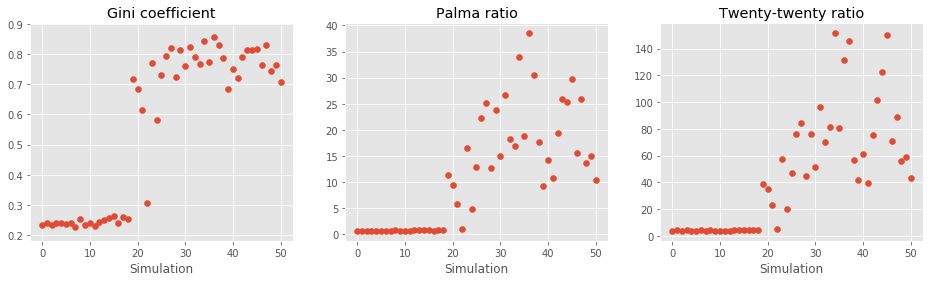

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[16,4])

ax1.scatter(range(len(ginis)), ginis)
ax2.scatter(range(len(palmas)), palmas)
ax3.scatter(range(len(twtws)), twtws)

ax3.set_title('Twenty-twenty ratio')
ax2.set_title('Palma ratio')
ax1.set_title('Gini coefficient')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Simulation')

#fig.savefig('gini_palma_twenty_evolution_bubble.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

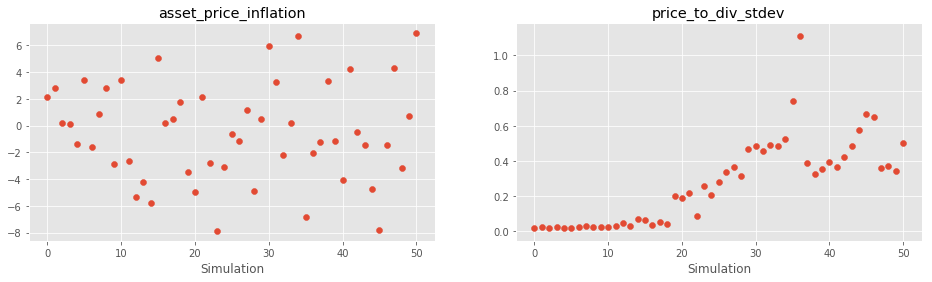

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.scatter(range(len(asset_price_inflation)), asset_price_inflation)
ax2.scatter(range(len(price_to_div_stdev)), price_to_div_stdev)


ax1.set_title('asset_price_inflation')
ax2.set_title('price_to_div_stdev')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Simulation')

## Regression


In [61]:
gini_res = sm.OLS(endog=data['gini'], exog=data[['const', 'share_chartists']], missing='drop').fit()
palma_res = sm.OLS(endog=data['palma'], exog=data[['const', 'share_chartists']], missing='drop').fit()
twtw_res = sm.OLS(endog=data['twtw'], exog=data[['const', 'share_chartists']], missing='drop').fit()
asset_p_inf_res = sm.OLS(endog=data['asset_price_infl'], exog=data[['const', 'lin_share_chartists']], missing='drop').fit()
pd_stdev_res = sm.OLS(endog=data['pd_vol'], exog=data[['const', 'lin_share_chartists']], missing='drop').fit()

In [62]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[gini_res, palma_res, twtw_res, asset_p_inf_res, pd_stdev_res],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Gini', 'Palma', '20-20', 'Asset-price inflation', 'Pd-volatility'],
                            info_dict=info_dict,
                            regressor_order=['const', 'share_chartists'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

                                               Table - OLS Regressions
                           Gini              Palma              20-20        Asset-price inflation    Pd-volatility   
----------------------------------------------------------------------------------------------------------------------
const               -0.2181***         2.9699***          4.3279***          -0.5512                -0.0581           
                    (0.0674)           (0.1952)           (0.1782)           (1.0632)               (0.0424)          
share_chartists     0.5125***          1.4017***          1.2824***                                                   
                    (0.0523)           (0.1513)           (0.1382)                                                    
lin_share_chartists                                                          -0.0469                0.6635***         
                                                                             (1.8143)           

# Experiment 2

Hypothesis, income inequality is a consequence of price fluctuations: 

Everyone is a fundamentalist. High noise 

In [19]:
params['strat_share_chartists'] = 0.001
params['average_learning_ability'] = 0.0
params['fundamentalist_horizon_multiplier'] = 0.2

In [23]:
stdev_fundamental = [x / 10.0 for x in range(5, 105, 20)]

In [26]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    params['std_fundamental'] = stdev_fundamental[seed]
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4


In [27]:
ginis = []
palmas = []
twtws = []
asset_price_inflation = []
price_to_div_stdev = []

for idx, traders in enumerate(trdrs):
    #print(t)
    money = np.array([x.var.money[-1] for x in trdrs[idx]])
    stocks = np.array([x.var.stocks[-1] for x in trdrs[idx]])
    wealth = money + (stocks * orbs[idx].tick_close_price[-1])
    
    asset_price_inflation.append(orbs[idx].tick_close_price[-1] - orbs[idx].tick_close_price[0])
    price_to_div_stdev.append((pd.Series(orbs[idx].tick_close_price) / pd.Series(orbs[idx].fundamental[1:])).std())
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palmas.append(share_top_10 / share_bottom_40)
    
    share_top_20 = sum(np.sort(wealth)[int(len(wealth) * 0.8):]) / sum(wealth)
    share_bottom_20 = sum(np.sort(wealth)[:int(len(wealth) * 0.2)]) / sum(wealth)
    twtws.append(share_top_20 / share_bottom_20)
    
    ginis.append(gini(wealth))

In [28]:
data = pd.DataFrame({'gini': np.log(ginis[1:]), 'palma': np.log(palmas[1:]), 'twtw': np.log(twtws[1:]), 'pd_vol': price_to_div_stdev[1:],
                     'stdev_fund': np.log(stdev_fundamental[1:]), 'lin_stdev_fund': stdev_fundamental[1:], 'asset_price_infl': asset_price_inflation[1:]})
data['const'] = 1

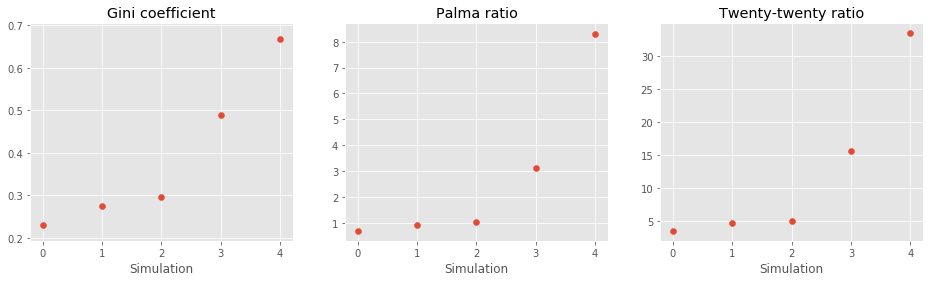

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[16,4])

ax1.scatter(range(len(ginis)), ginis)
ax2.scatter(range(len(palmas)), palmas)
ax3.scatter(range(len(twtws)), twtws)

ax3.set_title('Twenty-twenty ratio')
ax2.set_title('Palma ratio')
ax1.set_title('Gini coefficient')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Simulation')


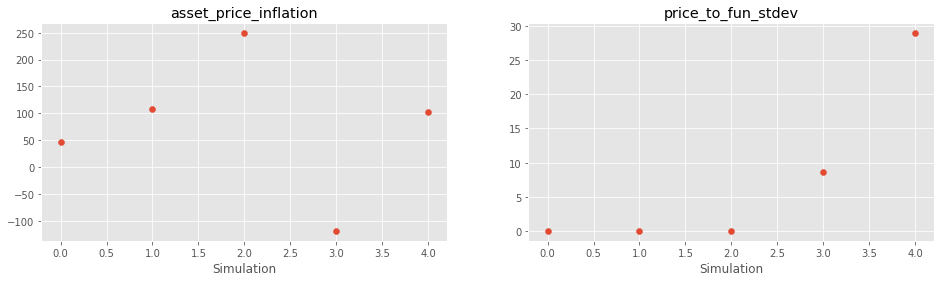

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.scatter(range(len(asset_price_inflation)), asset_price_inflation)
ax2.scatter(range(len(price_to_div_stdev)), price_to_div_stdev)


ax1.set_title('asset_price_inflation')
ax2.set_title('price_to_fun_stdev')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Simulation')

Text(0, 0.5, 'PF ratio')

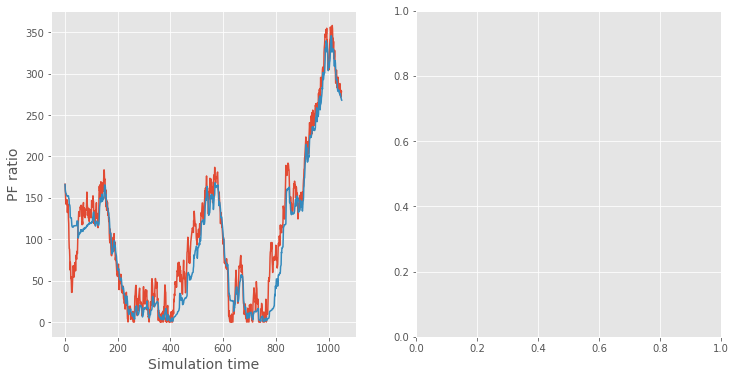

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

#ax1.plot(mc_returns.index, mc_returns[1], label='returns')
ax1.plot(range(len(orbs[idx].fundamental[1:])), orbs[idx].fundamental[1:], label='fundamental')
ax1.plot(range(len(orbs[idx].tick_close_price[1:])), orbs[idx].tick_close_price[1:], label='fundamental')

ax1.set_xlabel('Simulation time', fontsize='14')
ax1.set_ylabel('PF ratio', fontsize='14')

